In [1]:
import time, os, sys, pickle, h5py, importlib, gc, copy, re, itertools, json, logging
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['NUMEXPR_NUM_THREADS'] = '8'
from tqdm.auto import tqdm, trange
from pathlib import Path
from util import config_logger
from util import openH5File, encode4h5, parse_suffix, config_logger


import numpy as np, pandas as pd, scipy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score

from umap import UMAP
import anndata as ad

import scanpy as sc

import torch
torch.set_num_threads(16)
from model import SpiceMix
from helper import evaluate_embedding_maynard2021 # This function is for the optional on-the-fly evaluation. This is not required for SpiceMix.
fn_eval = evaluate_embedding_maynard2021

from matplotlib import pyplot as plt
from load_data import load_expression, load_edges, load_genelist

import seaborn as sns
sns.set_style("white")
%matplotlib inline
%config InlineBackend.figure_format='retina'

logger = config_logger(logging.getLogger(__name__))

### read in liver data

In [2]:
df_counts = pd.read_csv('../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/Liver_smi/data/livcan_counts_y4_x69.csv')
df_counts.head()

,AATK,ABL1,ABL2,ACACB,ACE,ACKR1,ACKR3,ACKR4,ACP5,ACTA2,...,WNT7A,WNT7B,WNT9A,XBP1,XCL1,XKR4,YBX3,YES1,ZBTB16,ZFP36
0,0.873008,-0.899111,-0.761059,-1.339173,0.568835,-0.555687,-0.683929,0.784943,0.059660,-0.857468,...,-0.467617,-0.686448,0.917134,-2.003820,1.273756,-0.395283,2.138706,0.332135,-1.831427,0.737800
1,-0.793585,-0.187628,-0.925050,0.176717,-0.914694,-0.675865,-0.831523,-0.826315,-1.173083,-1.041842,...,-0.568871,0.355286,0.499942,-1.246374,0.685614,-0.480947,-0.652747,0.903774,-0.998982,-1.820885
2,0.120180,-0.525507,-1.092105,-0.900105,-1.079920,-0.798552,-0.982008,-0.975875,0.743403,-1.229429,...,-0.672314,-0.985607,-0.918791,2.063357,0.207202,-0.568507,2.132701,-0.396364,-2.302735,1.978299
3,3.400688,-0.375407,-0.317463,-0.561453,-0.313883,-0.231536,-0.285158,-0.283361,2.070635,-0.357911,...,-0.194767,-0.286212,-0.266653,-0.848054,-0.379477,-0.164597,-0.805350,-0.352301,-0.957774,0.481391
4,-0.584347,0.428393,-0.681505,0.441121,0.803433,-0.497467,-0.612370,-0.608522,-0.865276,-0.767956,...,-0.418586,-0.614627,1.167544,-1.263150,-0.813996,-0.353815,2.256925,-0.755973,-1.553186,-0.504792


In [3]:
df_meta = pd.read_csv('../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/Liver_smi/data/livcan_meta_y4_x69.csv')
df_meta.head()

,RNA_pca_cluster_default,RNA_pca_cluster_default.1,orig.ident,nCount_RNA,nFeature_RNA,nCount_negprobes,nFeature_negprobes,nCount_falsecode,nFeature_falsecode,fov,...,nCount,nCountPerCell,nFeaturePerCell,propNegativeCellAvg,complexityCellAvg,errorCtPerCellEstimate,percOfDataFromErrorPerCell,qcFlagsFOV,cellType,niche
0,5,8,c,2974,453,0,0,2,2,305,...,1276579,1047.234619,217.455291,0.000644,3.677354,56.111567,0.053581,Pass,tumor_2,tumor subtype
1,14,2,c,4406,463,1,1,4,4,307,...,1451940,1269.178322,235.490385,0.000674,4.149606,70.192308,0.055305,Pass,tumor_1,tumor
2,14,2,c,6162,537,2,2,4,4,307,...,1451940,1269.178322,235.490385,0.000674,4.149606,70.192308,0.055305,Pass,tumor_1,tumor
3,19,19,c,515,262,1,1,16,16,307,...,1451940,1269.178322,235.490385,0.000674,4.149606,70.192308,0.055305,Pass,CD3+.alpha.beta.T.cells,tumor
4,2,6,c,2382,353,2,2,8,8,307,...,1451940,1269.178322,235.490385,0.000674,4.149606,70.192308,0.055305,Pass,tumor_1,tumor


In [4]:
cellpop = np.load('../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/Liver_smi/data/469_feature_labels_res0.5.npy')
df_meta['cellpop'] = cellpop

In [5]:
df_meta.columns

Index(['RNA_pca_cluster_default', 'RNA_pca_cluster_default.1', 'orig.ident',
       'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes',
       'nCount_falsecode', 'nFeature_falsecode', 'fov', 'Area', 'AspectRatio',
       'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CK8.18',
       'Max.CK8.18', 'Mean.Membrane', 'Max.Membrane', 'Mean.CD45', 'Max.CD45',
       'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'Run_name',
       'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Mean.Yellow',
       'Max.Yellow', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'cell_ID', 'x_FOV_px',
       'y_FOV_px', 'x_slide_mm', 'y_slide_mm', 'propNegative', 'complexity',
       'errorCtEstimate', 'percOfDataFromError', 'qcFlagsRNACounts',
       'qcFlagsCellCounts', 'qcFlagsCellPropNeg', 'qcFlagsCellComplex',
       'qcFlagsCellArea', 'median_negprobes', 'negprobes_quantile_0.9',
       'median_RNA', 'RNA_quantile_0.9', 'nCell', 'nCount', 'nCountPerCell',
       'nFeaturePerCell', 'propNe

### save files for spicemix

In [5]:
save_path = "../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/Liver_smi/data/spicemix_use/files/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [9]:
features_names = df_counts.columns

np.savetxt(os.path.join(save_path, f"expression_469.txt"), df_counts) #####

# save neighborhood
locations = df_meta[['x_slide_mm', 'y_slide_mm']].to_numpy()
adata = ad.AnnData(df_counts, dtype=np.float32)
adata.obsm["spatial"] = locations
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=None, use_rep='spatial')
rows, cols = adata.obsp['connectivities'].nonzero()
edges = np.array([rows, cols]).T

file = open(os.path.join(save_path, f"neighborhood_469.txt"),'w') ######
for i in range(rows.shape[0]):
    file.write(str(rows[i])+" "+str(cols[i])+"\n")
file.close()

# save cell type
file = open(os.path.join(save_path, f"genes_469.txt"),'w') #####
for item in features_names:
    file.write(item+"\n")
file.close()

file = open(os.path.join(save_path, f"celltypes_469.txt"),'w') # note this does not have human intervention annotaion
for i in range(df_meta.shape[0]):
    file.write(df_meta['cellpop'].astype(str)[i] + "\n")
file.close()

/home/bokai/miniconda3/envs/spicemix/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### spicemix start running

In [85]:
# -- specify device
context = dict(device='cpu', dtype=torch.float64)
# context = dict(device='cpu', dtype=torch.float64)
context_Y = context
# -- specify dataset
path2dataset = Path('../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/Liver_smi/data/spicemix_use/')
#repli_list = list(df['fov'].unique().astype(str))
repli_list = ['469']

In [86]:
from model import SpiceMix
from helper import evaluate_embedding_maynard2021 # This function is for the optional on-the-fly evaluation. This is not required for SpiceMix.
fn_eval = evaluate_embedding_maynard2021

np.random.seed(0)

K, num_pcs, n_neighbors, res_lo, res_hi = 30, 20, 15, .5, 2.

path2result = path2dataset / 'results' / 'SpiceMix.h5'
os.makedirs(path2result.parent, exist_ok=True)
if os.path.exists(path2result):
    os.remove(path2result)
    
obj = SpiceMix(
    K=K,
    lambda_Sigma_x_inv=1e-6, power_Sigma_x_inv=2,
    repli_list=repli_list,
    context=context,
    context_Y=context,
    path2result=path2result,
)
obj.load_dataset(path2dataset)

2024-01-18 17:12:18:INFO:result file = ../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/Liver_smi/data/spicemix_use/results/SpiceMix.h5
2024-01-18 17:12:43:INFO:Loaded 54867 cells and 1000 genes from ../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/Liver_smi/data/spicemix_use/files/expression_469.txt
2024-01-18 17:12:43:INFO:Loaded 1000 genes from ../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/Liver_smi/data/spicemix_use/files/genes_469.txt
2024-01-18 17:12:46:WARNING:Detected 432233 duplicate edge(s) from 864466 loaded edges. Duplicate edges are discarded.
2024-01-18 17:12:46:INFO:Loaded 432233 edges from ../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/Liver_smi/data/spicemix_use/files/neighborhood_469.txt


In [87]:
!ls ../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/Liver_smi/data/spicemix_use/

files  results


In [89]:
latent_states = [X.cpu().numpy() for X in obj.Xs]
latent_state_cat = np.concatenate(latent_states, axis=0)

/home/bokai/miniconda3/envs/spicemix/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'annotation' as categorical


<AxesSubplot:title={'center':'annotation'}, xlabel='UMAP1', ylabel='UMAP2'>

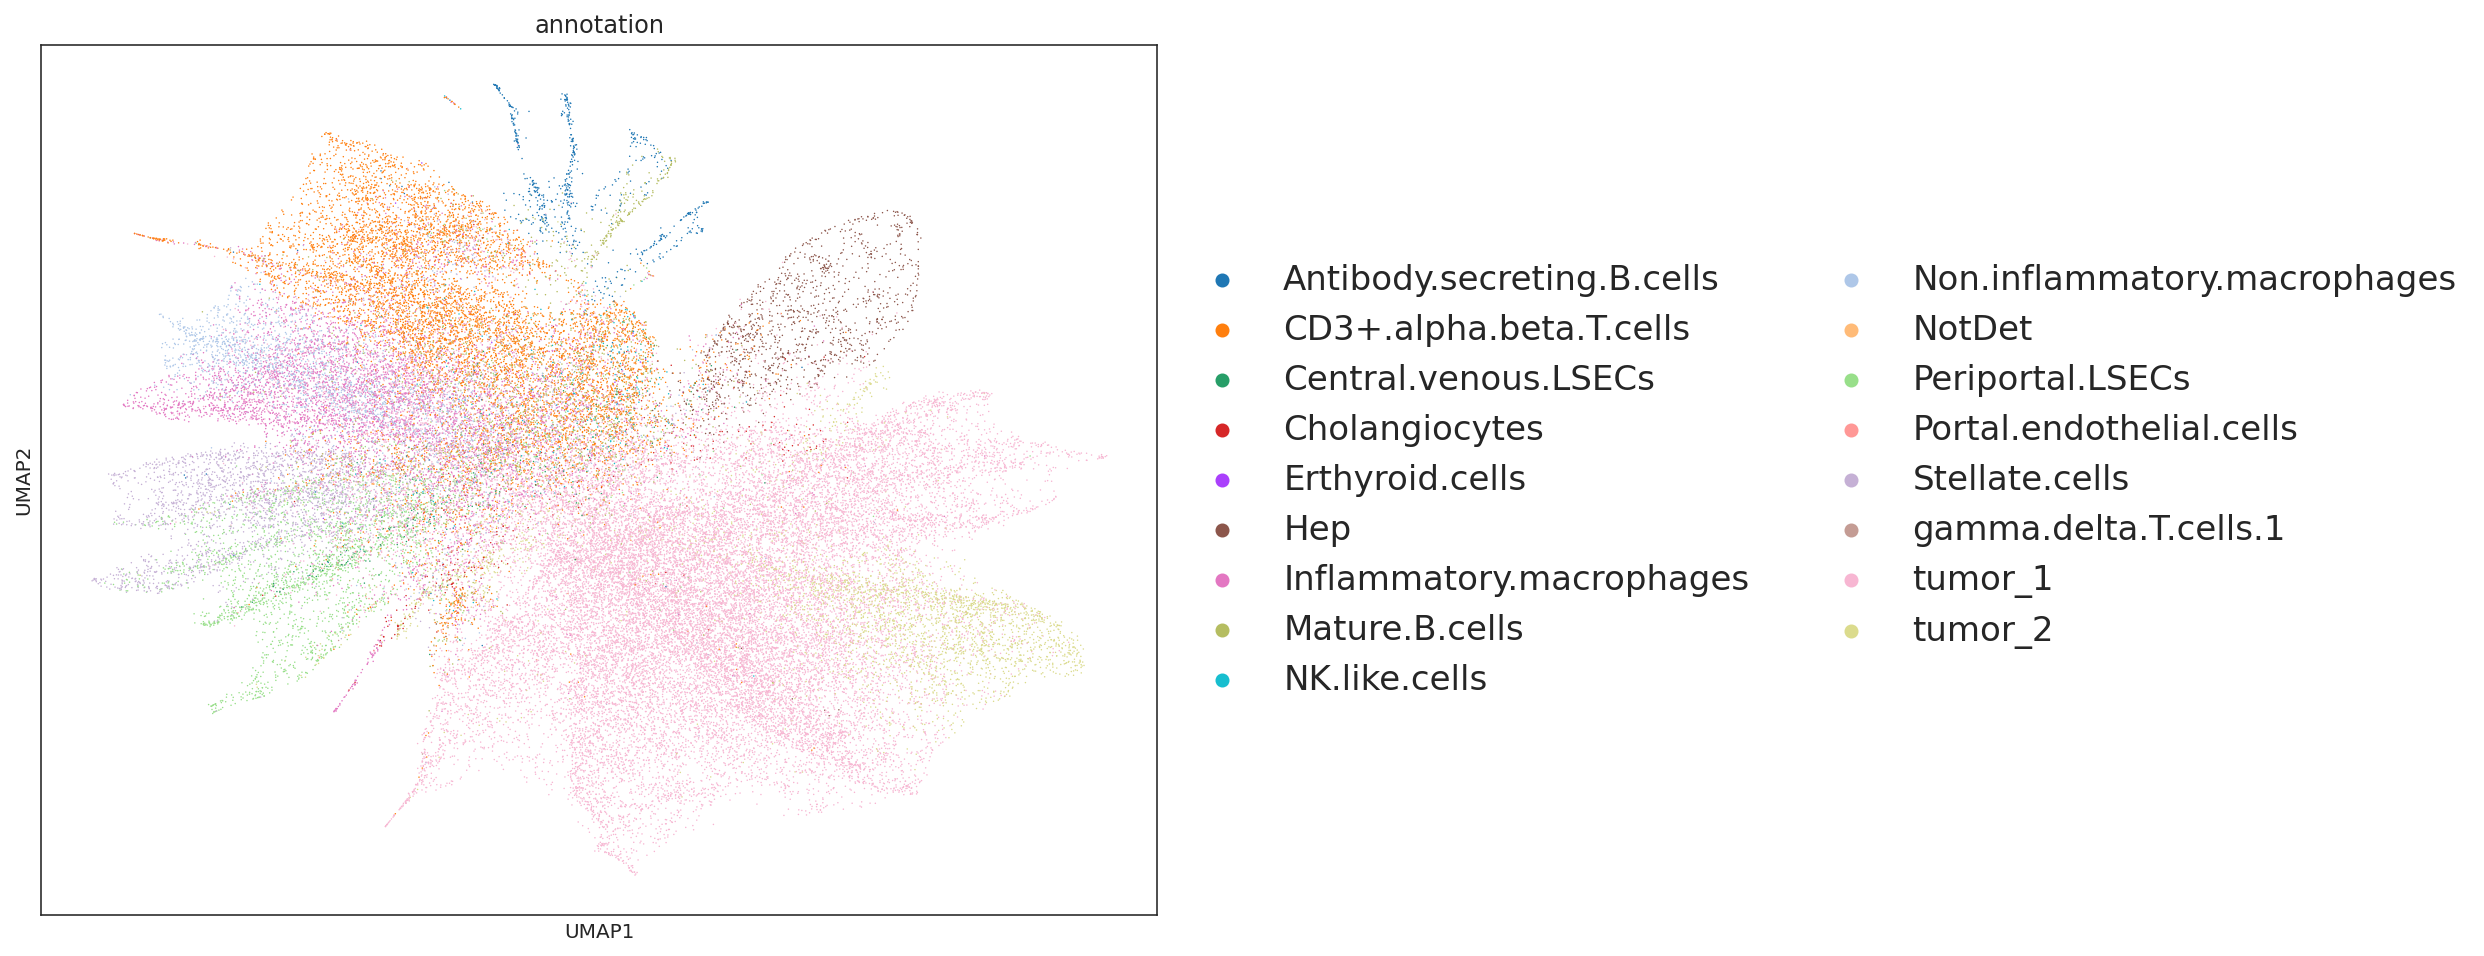

In [90]:
# full feature embeddings
feature_adata = ad.AnnData(latent_state_cat)
sc.pp.scale(feature_adata)
feature_adata.obs['annotation'] = list(df_meta['cellType'])
sc.tl.pca(feature_adata, svd_solver='arpack')
# sc.pp.neighbors(feature_adata, n_neighbors=10, n_pcs=40)
sc.pp.neighbors(feature_adata, n_neighbors=10)
sc.tl.umap(feature_adata)
plt.rcParams["figure.figsize"] = (10,8)
sc.pl.umap(feature_adata, color='annotation', legend_fontsize=17, show=False)

In [91]:
latent_state_cat.mean(axis = 0)

array([ 1.02022467,  1.02053979, 12.88829361,  1.40445393,  2.03942046,
        1.00166291,  2.69062556,  3.11260798,  1.62130925,  0.4179878 ,
        0.54655562,  1.78505226,  2.0115904 ,  1.95759714,  0.22409434,
        1.90216574,  0.22043628,  1.00670784,  0.3221757 ,  0.54862757,
        0.58477838,  0.29576456,  4.3739452 ,  0.9468706 ,  1.78998632,
        0.74045732,  0.14353191,  0.63063499,  0.56842024,  0.52474738])

In [92]:
np.save('../../spatial_clust/spatial-clust-scripts/ipynb/Bokai_reorg/Liver_smi/data/spicemix_469_embedding.npy', latent_state_cat) 

In [93]:
latent_state_cat.shape

(54867, 30)